In [1]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import sys
import h5py
import matplotlib.gridspec as gridspec

# shouldn't need this if have illustris_python properly in python path! todo: check if fixed upon reload
sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

sys.path.insert(1, '../code')
import utils
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
tng_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4'
tng_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark'
base_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4/output'
base_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark/output'
snap_num_str = '099'
snap_num = int(snap_num_str)

In [94]:
ipart_dm = il.snapshot.partTypeNum('dm') # 0
ipart_star = il.snapshot.partTypeNum('stars') # 4
mass_multiplier = 1e10

In [4]:
with h5py.File(f'{base_path_hydro}/snapdir_{snap_num_str}/snap_{snap_num_str}.0.hdf5','r') as f:
    header = dict( f['Header'].attrs.items() )

m_dmpart = header['MassTable'][1] # this times 10^10 msun/h
print(f"Mass of dark matter particles: {m_dmpart*1e10:.4e} Msun/h")

Mass of dark matter particles: 1.5737e+08 Msun/h


Load in dark and full sims


In [5]:
fields = ['SubhaloMass','SubhaloPos','SubhaloMassType', 'SubhaloLenType', 'SubhaloHalfmassRad', 'SubhaloGrNr']

subhalos_hydro = il.groupcat.loadSubhalos(base_path_hydro,snap_num,fields=fields)
halos_hydro = il.groupcat.loadHalos(base_path_hydro,snap_num)

subhalos_dark = il.groupcat.loadSubhalos(base_path_dark,snap_num,fields=fields)
halos_dark = il.groupcat.loadHalos(base_path_dark,snap_num)

Create corresponding array of halo IDS

In [6]:
# I think the halo IDs are just the place in the original list; make this explicit
idxs_halos_hydro_all = np.array(list(range(halos_hydro['count'])))
idxs_halos_dark_all = np.array(list(range(halos_dark['count'])))

Load twin-matching file

In [7]:
f = h5py.File(f'{tng_path_hydro}/postprocessing/subhalo_matching_to_dark.hdf5','r')
# two different matching algorithms: 'SubhaloIndexDark_LHaloTree' & 'SubhaloIndexDark_SubLink'. choosing first for now
subhalo_full_to_dark_inds = f[f'Snapshot_{snap_num}']['SubhaloIndexDark_LHaloTree']

Build dicts to match subhalos both ways. If a full subhalo has no dark subhalo twin, exclude it.

In [8]:
subhalo_full_to_dark_dict = {}
subhalo_dark_to_full_dict = {}
for i in range(len(subhalo_full_to_dark_inds)):
    idx_full = i
    idx_dark = subhalo_full_to_dark_inds[idx_full]
    if idx_dark == -1:
        continue
    subhalo_dark_to_full_dict[idx_dark] = idx_full
    subhalo_full_to_dark_dict[idx_full] = idx_dark

Get most massive subhalo in each dark halo; then find that subhalo's twin in the full sim. If it doesn't have a twin (aka not in dict), exclude. Also, if there are no star particles in the matched subhalo in the full sim, exclude.

_GroupFirstSub: Index into the Subhalo table of the first/primary/most massive Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! In this case, a value of -1 indicates that this FoF group has no subhalos._

In [9]:
halos_dark['GroupFirstSub'] = halos_dark['GroupFirstSub'].astype('int32')
mask_has_subhalos = np.where(halos_dark['GroupFirstSub'] >= 0) # filter out halos with no subhalos
epsilon = 1e-6

idxs_halos_dark_withsubhalos = idxs_halos_dark_all[mask_has_subhalos]
idxs_largestsubs_dark_all = halos_dark['GroupFirstSub'][mask_has_subhalos]

halo_dicts = []
for i, idx_halo_dark in enumerate(idxs_halos_dark_withsubhalos):
    
    idx_largestsub_dark = idxs_largestsubs_dark_all[i]
    if idx_largestsub_dark in subhalo_dark_to_full_dict:
        
        halo_dict = {}
        
        # This is the index of the hydro subhalo that is the twin of the largest subhalo in the dark halo
        idx_subtwin_hydro = subhalo_dark_to_full_dict[idx_largestsub_dark]
        # This is that hydro subhalo's parent halo in the hydro sim
        idx_halo_hydro = subhalos_hydro['SubhaloGrNr'][idx_subtwin_hydro]
        # This is the largest hydro subhalo of that hydro halo
        idx_subhalo_hydro = halos_hydro['GroupFirstSub'][idx_halo_hydro]

        halo_dict['idx_halo_dark'] = idx_halo_dark
        halo_dict['idx_subhalo_hydro'] = idx_subhalo_hydro
        halo_dict['idx_subhalo_dark'] = idx_largestsub_dark
        halo_dict['idx_halo_hydro'] = idx_halo_hydro
        
        halo_dicts.append(halo_dict)
        
halo_dicts = np.array(halo_dicts)

In [60]:
print(len(idxs_halos_dark_all))
print(len(idxs_halos_dark_withsubhalos))
print(len(subhalo_dark_to_full_dict))
print(len(halo_dicts))
N_halos = len(halo_dicts)
idx_halos_in_halodict = np.arange(N_halos)

18824
17738
18392
15519


In [84]:
y_scalar = np.empty(N_halos) # 1 mass dimension

for i_hd, halo_dict in enumerate(halo_dicts):
    
    idx_halo_dark = halo_dict['idx_halo_dark']
    halo_dict['mass_dark_halo_dm'] = halos_dark['GroupMassType'][:,ipart_dm][idx_halo_dark]

    idx_halo_hydro = halo_dict['idx_halo_hydro']
    halo_dict['mass_hydro_halo_dm'] = halos_hydro['GroupMassType'][:,ipart_dm][idx_halo_hydro]
    halo_dict['mass_hydro_halo_star'] = halos_hydro['GroupMassType'][:,ipart_star][idx_halo_hydro]
    
    idx_subhalo_hydro = halo_dict['idx_subhalo_hydro']
    halo_dict['mass_hydro_subhalo_star'] = subhalos_hydro['SubhaloMassType'][:,ipart_star][idx_subhalo_hydro]
    
    #y_scalar[i_hd] = halo_dict['mass_hydro_halo_star']
    y_scalar[i_hd] = halo_dict['mass_dark_halo_dm']

## Compute scalar features

In [85]:
N_halos_subset = 100

idx_subset = np.random.choice(idx_halos_in_halodict, size=N_halos_subset)
halo_dicts_subset = halo_dicts[idx_subset]
y_scalar_subset = y_scalar[idx_subset]

In [86]:
r_edges = np.array([0,500]) #in ckpc/h. Typical halo sizes 50-200 ckpc/h. boxsize 51.7 Mpc
n_rbins = len(r_edges) - 1
print(r_edges)

l_arr = np.array([0, 1, 2])
n_arr = np.arange(n_rbins)

[  0 500]


In [87]:
g_arrs_halos = []
g_normed_arrs_halos = []

for i_hd, halo_dict in enumerate(halo_dicts_subset):
    idx_halo_dark = halo_dict['idx_halo_dark']
    halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,idx_halo_dark,'dm')
    x_halo_dark_dm = halo_dark_dm['Coordinates']
    x_halo_dark_dm_com = np.mean(x_halo_dark_dm, axis=0)
    
    # Subtract off center of mass for each halo
    x_data_halo = x_halo_dark_dm - x_halo_dark_dm_com
    #print(min(x_data_halo[:,0]), max(x_data_halo[:,0]))
    g_arrs, g_normed_arrs = scalars.get_geometric_features(x_data_halo, r_edges, l_arr, n_arr, m_dmpart)
    g_arrs_halos.append(g_arrs)
    g_normed_arrs_halos.append(g_normed_arrs)

In [88]:
print([g.shape for g in g_arrs_halos[0]])
print([g.shape for g in g_normed_arrs_halos[0]])

[(1,), (1, 3), (1, 3, 3)]
[(1,), (1, 3), (1, 3, 3)]


### Plotting features

In [89]:
color_mass = np.linspace(min(y_scalar), max(y_scalar), len(y_scalar))
color_mass_norm = matplotlib.colors.Normalize(vmin=min(y_scalar), vmax=max(y_scalar))

cmap = matplotlib.cm.get_cmap('plasma')

In [90]:
show_intermediate_plots = True

(100,) (100,)


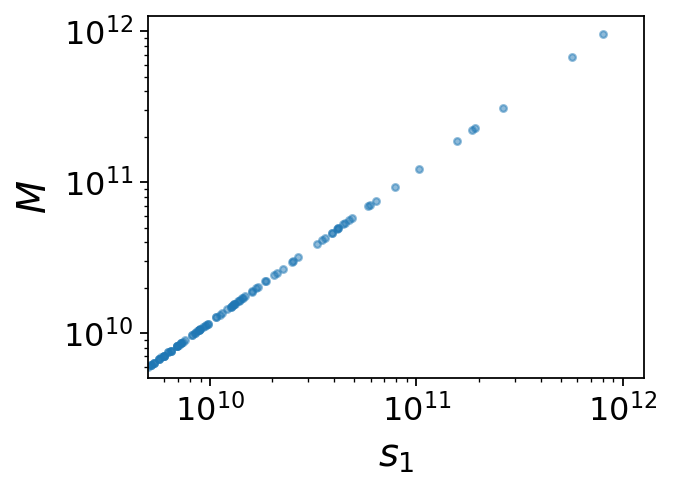

In [98]:
if show_intermediate_plots:
    plt.figure(figsize=(4,3))

    l = 0
    #print(np.array(g_arrs_halos[:][l]).shape)
    #print(y_scalar.shape)
    s1_features = np.zeros(N_halos_subset)
    for i_hd in range(N_halos_subset):
        #print(g_arrs_halos[i_hd][l])
        s1_features[i_hd] = g_arrs_halos[i_hd][l][0]
    print(s1_features.shape, y_scalar_subset.shape)
    plt.scatter(s1_features*mass_multiplier, y_scalar_subset*mass_multiplier, ls='-', marker='.', alpha=0.5)

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$s_1$')
    plt.ylabel(r'$M$')
    
    plt.xlim([min(s1_features[np.nonzero(s1_features)])*mass_multiplier, 
              max(s1_features)*mass_multiplier])
    plt.ylim([min(s1_features[np.nonzero(s1_features)])*mass_multiplier, 
          max(s1_features)*mass_multiplier])